In [1]:
import numpy as np
import pandas as pd
import math 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
print(os.getcwd())
from scipy import stats
from scipy.stats import chi2_contingency #卡方檢定 & Crames'v
import statistics
from IPython.display import display  #在jupyter notebook 使用預覽畫面
import sklearn
print(sklearn.__version__)
#如果只有 0.19 記得要更新至 最新版本
%matplotlib inline
# 特徵選取會用到的函數
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

import pingouin as pg  # ANOVA 單因子及變數顯著性分析 (https://pingouin-stats.org/build/html/index.html)
import researchpy      #Cramér's V（克拉梅V係數）
plt.rcParams['font.family'] = 'Microsoft JhengHei' #顯示中文字(Windows)
#plt.rcParams['font.family'] = 'Heiti TC' #顯示中文字(Mac OS)


D:\Python3.9\AI數學馬拉松
1.5.1


In [97]:
hawkeye_data = pd.read_excel("D:\數據分析科\鷹眼\警示戶資料.xlsx")

In [98]:
hawkeye_data.info()
hawkeye_data['帳號'] = hawkeye_data['帳號'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10286 entries, 0 to 10285
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   身分證              10286 non-null  object        
 1   帳號               10286 non-null  int64         
 2   交易日 年/月/日        10286 non-null  datetime64[ns]
 3   行業別名稱            10286 non-null  object        
 4   薪轉戶註記            10276 non-null  object        
 5   行員註記             10276 non-null  object        
 6   警示戶註記            10276 non-null  object        
 7   黑名單註記            10276 non-null  object        
 8   是否進行KYC註記        10276 non-null  object        
 9   拒往註記             10276 non-null  object        
 10  GENDER           10276 non-null  object        
 11  EMAIL            6876 non-null   object        
 12  性質別_CHAR_CODE    10286 non-null  object        
 13  管制性帳戶            10286 non-null  object        
 14  客戶狀態             10286 non-null  objec

In [99]:
hawkeye_data.rename(columns  = {'交易日 年/月/日':'交易日'}, inplace = True)

In [100]:
hawkeye_data.loc[:,~hawkeye_data.columns.str.contains('交易日')].describe()

,年齡,金融卡使用次數
count,9603.000000,10286.000000
mean,109.180673,59.259382
std,127.742816,391.721844
min,1.000000,0.000000
25%,44.000000,0.000000
50%,71.000000,0.000000
75%,130.000000,36.000000
max,1848.000000,14469.000000


In [101]:
hawkeye_data.head(10)

,身分證,帳號,交易日,行業別名稱,薪轉戶註記,行員註記,警示戶註記,黑名單註記,是否進行KYC註記,拒往註記,...,管制性帳戶,客戶狀態,客戶狀況(一),金融卡轉帳狀況,止扣原因,金融卡狀況,性質別_CHAR_CODE.1,利率別,年齡,金融卡使用次數
0,A100095751,202210083750,2025-07-23,(六)私人,N,N,N,N,N,N,...,2.衍生管制帳戶,05.結清戶,0,0.非約定轉帳,0,7.註銷,000.一般戶,10.活期儲蓄,152.0,0
1,A100215155,226206004191,2025-09-17,(六)私人,N,N,N,N,Y,N,...,2.衍生管制帳戶,05.結清戶,0,1.兩者皆有,0,7.註銷,010.證券戶,06.活期儲蓄(證券),144.0,4
2,A100544722,228210308050,2025-09-25,(六)私人,N,N,N,N,N,N,...,2.衍生管制帳戶,05.結清戶,0,3.皆無轉帳功能,0,0.未領用,000.一般戶,10.活期儲蓄,156.0,0
3,A100957381,214210926852,2025-07-23,(六)私人,N,N,N,N,N,N,...,2.衍生管制帳戶,05.結清戶,0,0.非約定轉帳,0,0.未領用,000.一般戶,10.活期儲蓄,243.0,0
4,A101592651,245210515200,2025-07-10,(六)私人,N,N,N,N,Y,N,...,2.衍生管制帳戶,05.結清戶,0,0.非約定轉帳,0,7.註銷,004.綜合存款戶,10.活期儲蓄,71.0,0
5,A101592651,245210515200,2025-09-11,(六)私人,N,N,N,N,Y,N,...,2.衍生管制帳戶,05.結清戶,0,0.非約定轉帳,0,7.註銷,004.綜合存款戶,10.活期儲蓄,213.0,0
6,A102050965,202210888979,2025-07-25,(六)私人,N,N,N,N,Y,N,...,2.衍生管制帳戶,05.結清戶,0,3.皆無轉帳功能,0,7.註銷,000.一般戶,10.活期儲蓄,83.0,0
7,A102050965,202210888979,2025-08-25,(六)私人,N,N,N,N,Y,N,...,2.衍生管制帳戶,05.結清戶,0,3.皆無轉帳功能,0,7.註銷,000.一般戶,10.活期儲蓄,83.0,0
8,A102050965,202210888979,2025-09-25,(六)私人,N,N,N,N,Y,N,...,2.衍生管制帳戶,05.結清戶,0,3.皆無轉帳功能,0,7.註銷,000.一般戶,10.活期儲蓄,83.0,0
9,A102050965,202210888979,2025-09-26,(六)私人,N,N,N,N,Y,N,...,2.衍生管制帳戶,05.結清戶,0,3.皆無轉帳功能,0,7.註銷,000.一般戶,10.活期儲蓄,166.0,0


In [102]:
hawkeye_data.shape

(10286, 23)

In [46]:
print(hawkeye_data[hawkeye_data['客戶狀況(一)']=='02.薪資轉帳戶'].groupby(['金融卡狀況'])[['金融卡狀況']].size().reset_index(name = '個數'),'\n')
print(hawkeye_data[hawkeye_data['客戶狀況(一)']=='02.薪資轉帳戶'].groupby(['客戶狀態'])[['客戶狀態']].size().reset_index(name = '個數'))

        金融卡狀況   個數
0       0.未領用  195
1       1.已使用  800
2  2.已啟用未變更密碼  229
3        6.遺失   25
4        7.註銷  432 

     客戶狀態    個數
0  00.正常戶   178
1  02.止扣戶  1055
2  05.結清戶   448


In [54]:
hawkeye_data[hawkeye_data['客戶狀況(一)']=='02.薪資轉帳戶'].groupby(['EMAIL'])[['EMAIL']].count()

,EMAIL
EMAIL,
0960618@gmail.com,8
314kxun@gmail.com,12
Ashleetsai.b@gmail.com,2
E22180111@gmail.com,1
NGOCDON.281100@GMAIL.COM,6
...,...
wu81952176@ymail.com,9
wu8366@yahoo.com.tw,5
x23235623@gmail.com,37


In [297]:
hawkeye_data_age = hawkeye_data_age.groupby('年齡')[['客戶狀況(一)']].value_counts().unstack().reset_index()
hawkeye_data_age.to_csv('hawkeye_data_age.csv', encoding = 'utf-8-sig')

C:\Users\b003087\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


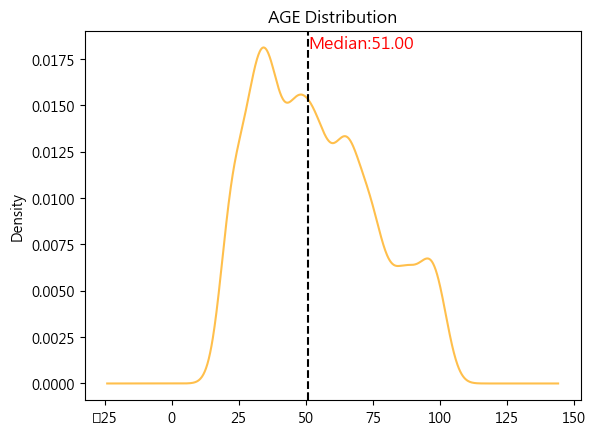

In [283]:
ax = hawkeye_data_age['年齡'].plot(kind = 'density',  
                             color = 'orange',
                           title = 'AGE Distribution', alpha = 0.7)
median_age = hawkeye_data_age['年齡'].median()
mean_age = hawkeye_data_age['年齡'].mean()
ax.axvline(median_age, color = 'black', linestyle = '--')
#ax.axvline(mean_age, color = 'green', linestyle = '--')
ax.text(median_age, ax.get_ylim()[1]*0.95, f'Median:{median_age:.2f}',color = 'red',fontsize = 12)
plt.show()

In [105]:
q_high = hawkeye_data['年齡'].quantile(q = 0.65)
q_low = hawkeye_data['年齡'].quantile(q = 0.001)
hawkeye_data_age = hawkeye_data[(hawkeye_data['年齡']<q_high) & (hawkeye_data['年齡']>q_low)]
hawkeye_data_age['年齡'].describe()

count    6171.000000
mean       53.767785
std        22.087135
min        18.000000
25%        35.000000
50%        51.000000
75%        69.000000
max       102.000000
Name: 年齡, dtype: float64

0   身分證              10286 non-null  object        
 1   帳號               10286 non-null  int64         
 2   交易日 年/月/日        10286 non-null  datetime64[ns]
 3   行業別名稱            10286 non-null  object        
 4   薪轉戶註記            10276 non-null  object        
 5   行員註記             10276 non-null  object        
 6   警示戶註記            10276 non-null  object        
 7   黑名單註記            10276 non-null  object        
 8   是否進行KYC註記        10276 non-null  object        
 9   拒往註記             10276 non-null  object        
 10  GENDER           10276 non-null  object        
 11  EMAIL            6876 non-null   object        
 12  性質別_CHAR_CODE    10286 non-null  object        
 13  管制性帳戶            10286 non-null  object        
 14  客戶狀態             10286 non-null  object        
 15  客戶狀況(一)          10286 non-null  object        
 16  金融卡轉帳狀況          10286 non-null  object        
 17  止扣原因             10286 non-null  object        
 18  金融卡狀況            10286 non-null  object        
 19  性質別_CHAR_CODE.1  10286 non-null  object        
 20  利率別              10286 non-null  object        
 21  年齡               9603 non-null   float64       
 22  金融卡使用次數          10286 non-null  int64 

In [232]:
hawkeye_data_age.groupby('身分證')[['GENDER','客戶狀況(一)']].value_counts().unstack()

In [269]:
hawkeye_data_cardsist.to_csv('hawkeye_data_cardsist.csv', encoding = 'utf-8-sig')

In [160]:
hawkeye_data_age.groupby(['止扣原因','金融卡轉帳狀況'])['客戶狀況(一)'].size().reset_index()

,止扣原因,金融卡轉帳狀況,客戶狀況(一)
0,0,0.非約定轉帳,1486
1,0,1.兩者皆有,434
2,0,2.約定轉帳,4
3,0,3.皆無轉帳功能,903
4,04.管制帳戶,0.非約定轉帳,2106
5,04.管制帳戶,1.兩者皆有,343
6,04.管制帳戶,3.皆無轉帳功能,708
7,06.02存摺掛失+04管制帳戶,0.非約定轉帳,21
8,06.02存摺掛失+04管制帳戶,3.皆無轉帳功能,8
9,12.04管制帳戶+08死亡凍結,0.非約定轉帳,13


In [156]:
print(hawkeye_data_age['身分證'].nunique())
hawkeye_data_age['帳號'].nunique()

1525


1581

In [174]:
hawkeye_data_age[hawkeye_data_age['客戶狀況(一)'] == '02.薪資轉帳戶'].groupby(['金融卡轉帳狀況'])['身分證'].size()

金融卡轉帳狀況
0.非約定轉帳     910
1.兩者皆有      141
3.皆無轉帳功能    328
Name: 身分證, dtype: int64

In [178]:
hawkeye_data_age[hawkeye_data_age['客戶狀況(一)'] == '02.薪資轉帳戶'].groupby(['金融卡轉帳狀況'])['身分證'].size().reset_index()

,金融卡轉帳狀況,身分證
0,0.非約定轉帳,910
1,1.兩者皆有,141
2,3.皆無轉帳功能,328


In [172]:
hawkeye_data_age.groupby(['客戶狀況(一)','金融卡狀況'])['身分證'].count().reset_index()

,客戶狀況(一),金融卡狀況,身分證
0,0,0.未領用,687
1,0,1.已使用,1533
2,0,2.已啟用未變更密碼,655
3,0,4.密碼錯誤三次鎖死,10
4,0,6.遺失,51
5,0,7.註銷,1671
6,0,9.申請,172
7,01.重要存款戶,1.已使用,13
8,02.薪資轉帳戶,0.未領用,176
9,02.薪資轉帳戶,1.已使用,642
